In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.metrics import f1_score
from keras.optimizers import RMSprop,Adam
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [14]:
base_data_dir = "C:\\Users\\prana\\Desktop\\Anaconda\\ML\\hand\\leapGestRecog"
gestures = ["01_palm", "02_l", "03_fist", "04_fist_moved", "05_thumb", "06_index", "07_ok", "08_palm_moved", "09_c", "10_down"]
data = []
image_size = (50,50)

for subject in range(10):
    subject_data_dir = os.path.join(base_data_dir, f"{subject:02d}")
    for gesture in gestures:
        gesture_dir = os.path.join(subject_data_dir, gesture)
        if os.path.exists(gesture_dir):
            for filename in os.listdir(gesture_dir):
                if filename.endswith(".png"):
                    image_path = os.path.join(gesture_dir, filename)
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    resized_image = cv2.resize(image, image_size)
                    data.append({"gesture": gesture, "image": resized_image})

total_data_count = len(data)
print(f"Total data count: {total_data_count}")

Total data count: 20000


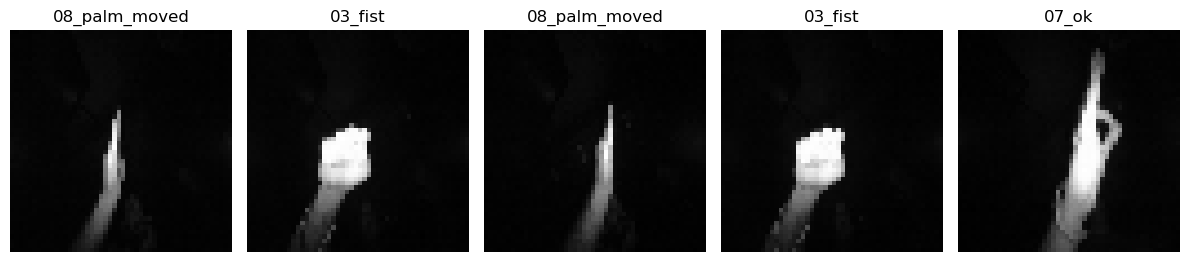

In [15]:
num_samples_to_display = 5
plt.figure(figsize=(12, 8))

for i in range(num_samples_to_display):
    random_index = random.randint(0, len(data) - 1)
    sample = data[random_index]
    gesture = sample['gesture']
    image = sample['image']
    
    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(gesture)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
df = pd.DataFrame(data)
X_train = np.array(df['image'].tolist())

X_train = X_train.reshape(-1, 50,50, 1)
X_train = X_train / 255.0

Y_train = df['gesture']

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

X_train shape: (20000, 50, 50, 1)
Y_train shape: (20000,)


In [17]:
label_encoder = LabelEncoder()
numerical_labels = label_encoder.fit_transform(Y_train)

onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_labels = onehot_encoder.fit_transform(numerical_labels.reshape(-1, 1))

In [18]:
X_train, X_val, onehot_labels_train, onehot_labels_val = train_test_split(X_train, onehot_labels, test_size=0.1, random_state=2)

In [19]:
model = Sequential()
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (50,50,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [20]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

epochs = 10
batch_size = 250

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [21]:
history = model.fit(X_train, onehot_labels_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, onehot_labels_val))

Epoch 1/10
72/72 [==============================] - 4s 37ms/step - loss: 1.3667 - accuracy: 0.5409 - val_loss: 0.5075 - val_accuracy: 0.8550
Epoch 2/10
72/72 [==============================] - 2s 34ms/step - loss: 0.4975 - accuracy: 0.8356 - val_loss: 0.1708 - val_accuracy: 0.9540
Epoch 3/10
72/72 [==============================] - 3s 35ms/step - loss: 0.2644 - accuracy: 0.9132 - val_loss: 0.0765 - val_accuracy: 0.9870
Epoch 4/10
72/72 [==============================] - 3s 37ms/step - loss: 0.1707 - accuracy: 0.9436 - val_loss: 0.0451 - val_accuracy: 0.9930
Epoch 5/10
72/72 [==============================] - 3s 36ms/step - loss: 0.1263 - accuracy: 0.9594 - val_loss: 0.0250 - val_accuracy: 0.9980
Epoch 6/10
72/72 [==============================] - 3s 35ms/step - loss: 0.1001 - accuracy: 0.9689 - val_loss: 0.0172 - val_accuracy: 0.9980
Epoch 7/10
72/72 [==============================] - 3s 35ms/step - loss: 0.0681 - accuracy: 0.9786 - val_loss: 0.0108 - val_accuracy: 0.9985
Epoch 8/10
72

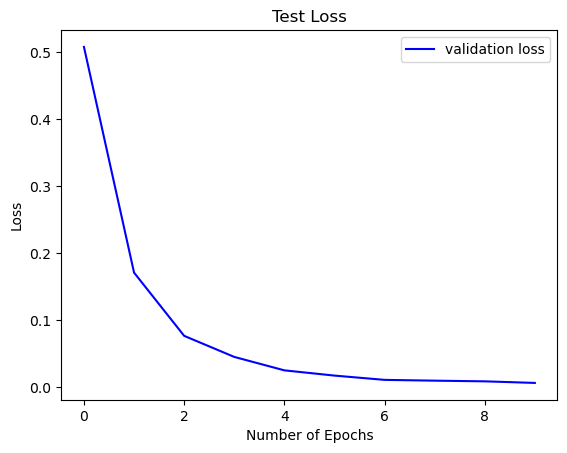

In [22]:
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [23]:
Y_pred = model.predict(X_val) 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(onehot_labels_val ,axis = 1)

63/63 [==============================] - 0s 3ms/step


In [24]:
f1 = f1_score(Y_true, Y_pred_classes, average='weighted')
print(f"Accuracy: {f1:.4f}")

Accuracy: 0.9990


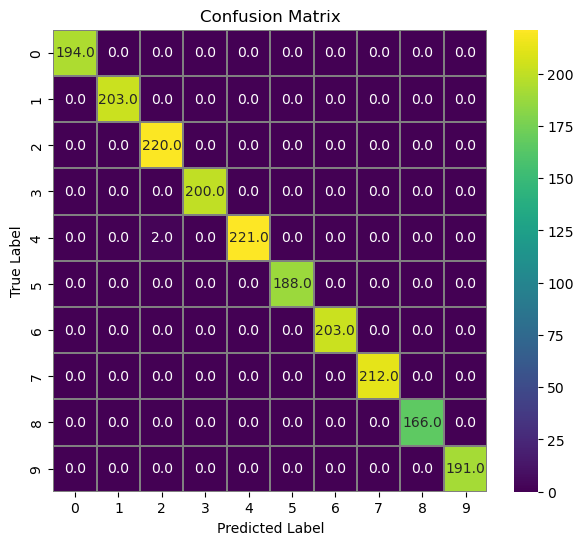

In [25]:
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(7, 6))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="viridis",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

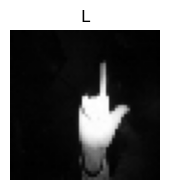

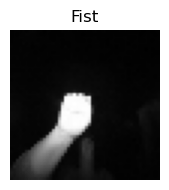

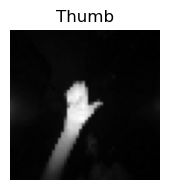

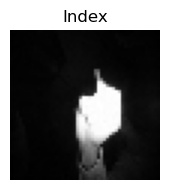

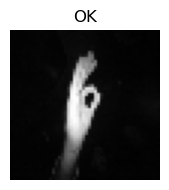

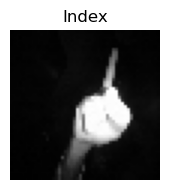

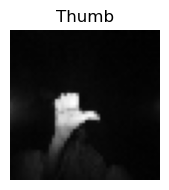

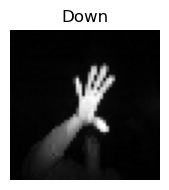

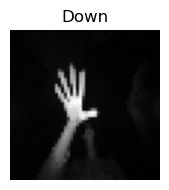

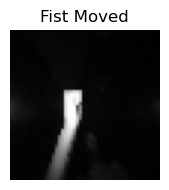

In [27]:
label_encoder = LabelEncoder()
label_encoder.fit(Y_true)

inverted_true = label_encoder.inverse_transform(Y_true)
inverted_pred = label_encoder.inverse_transform(Y_pred_classes)

label_map = {0: 'Palm', 1: 'L', 2: 'Fist', 3: 'Fist Moved', 4: 'Thumb', 5: 'Index', 6: 'OK', 7: 'Palm Moved', 8: 'C', 9: 'Down'}

inverted_true_names = [label_map.get(label, label) for label in inverted_true]
inverted_pred_names = [label_map.get(label, label) for label in inverted_pred]

sample_indices = np.random.choice(len(X_val), size=10, replace=False)

for idx in sample_indices:
    plt.figure(figsize=(3, 2))

    plt.imshow(X_val[idx].reshape(50, 50), cmap='gray')
    plt.title(f"{inverted_true_names[idx]}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()